In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [183]:
df=pd.read_csv("Iris.data")
df = df.dropna(axis=1, how='all')
df.columns = ['sepal_length','sepal_width','petal_length','petal_width','species']
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa
...,...,...,...,...,...
144,6.7,3.0,5.2,2.3,Iris-virginica
145,6.3,2.5,5.0,1.9,Iris-virginica
146,6.5,3.0,5.2,2.0,Iris-virginica
147,6.2,3.4,5.4,2.3,Iris-virginica


In [184]:
df.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [185]:
X = df[["sepal_length", "sepal_width", "petal_length", "petal_width"]].values
le = LabelEncoder()
df['species']= le.fit_transform(df["species"].values)  # 0,1,2
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,4.9,3.0,1.4,0.2,0
1,4.7,3.2,1.3,0.2,0
2,4.6,3.1,1.5,0.2,0
3,5.0,3.6,1.4,0.2,0
4,5.4,3.9,1.7,0.4,0
...,...,...,...,...,...
144,6.7,3.0,5.2,2.3,2
145,6.3,2.5,5.0,1.9,2
146,6.5,3.0,5.2,2.0,2
147,6.2,3.4,5.4,2.3,2


In [186]:
# ---------- Train/test split ----------
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

In [187]:

# ---------- Scaling ----------
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [189]:
def evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")


In [190]:
# Decision Tree (CART)
dt = DecisionTreeClassifier(random_state=42)
evaluate(dt,"Decision Tree")


=== Decision Tree ===
Accuracy : 0.9333
Precision: 0.9444
Recall   : 0.9333
F1 Score : 0.9327


In [191]:
# k-NN (k=5)
knn = KNeighborsClassifier(n_neighbors=5)
evaluate(knn,"K-Nearest Neighbours")


=== K-Nearest Neighbours ===
Accuracy : 0.9778
Precision: 0.9792
Recall   : 0.9778
F1 Score : 0.9778


In [192]:
class FuzzyKNN:
    def __init__(self, n_neighbors=5, m=2.0, eps=1e-8):
        self.k = n_neighbors
        self.m = m
        self.eps = eps

    def fit(self, X, y):
        self.X = np.asarray(X)
        self.y = np.asarray(y)
        self.classes_ = np.unique(self.y)
        return self

    def _weights(self, distances):
        exponent = 2.0 / (self.m - 1.0)
        return 1.0 / (distances ** exponent + self.eps)

    def predict_proba(self, X):
        X = np.asarray(X)
        proba = np.zeros((X.shape[0], len(self.classes_)))
        for i, xi in enumerate(X):
            d = np.linalg.norm(self.X - xi, axis=1)
            idx = np.argsort(d)[:self.k]
            d_k = d[idx]
            y_k = self.y[idx]
            w = self._weights(d_k)
            for j, c in enumerate(self.classes_):
                proba[i, j] = np.sum(w[y_k == c])
            s = proba[i].sum()
            proba[i] = proba[i] / s if s > 0 else np.ones(len(self.classes_)) / len(self.classes_)
        return proba

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

In [193]:
fnn=FuzzyKNN(n_neighbors=5, m=2.0)
evaluate(fnn,"Fuzzy KNN")


=== Fuzzy KNN ===
Accuracy : 0.9556
Precision: 0.9608
Recall   : 0.9556
F1 Score : 0.9554


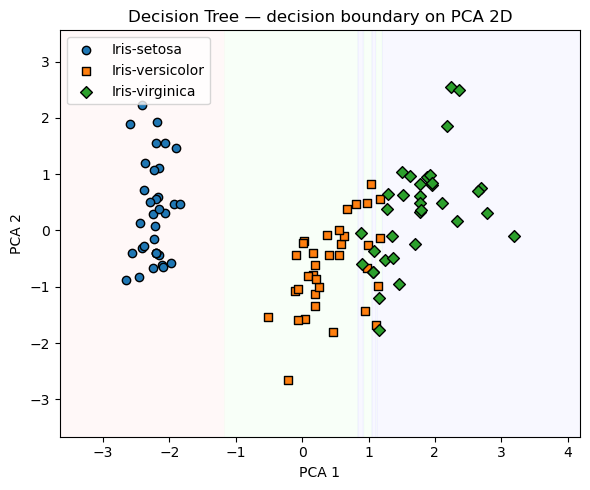

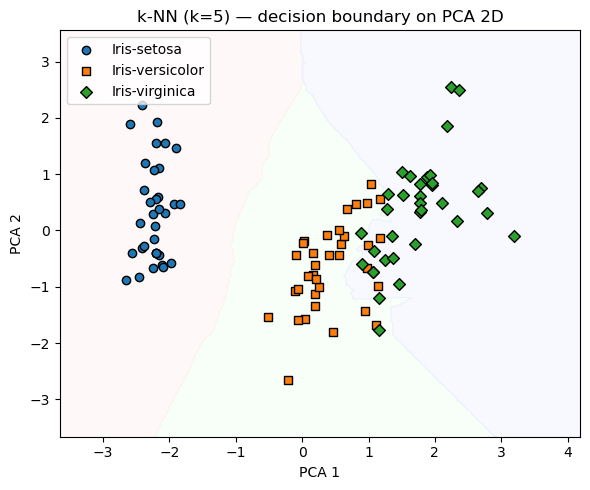

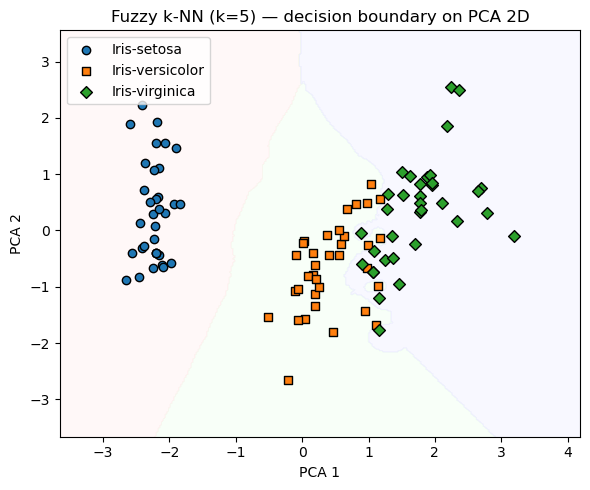

Done.


In [200]:
# ---------- 6) PCA 2D for visualization ----------
pca = PCA(n_components=2, random_state=42).fit(X_train_s)
X_train_pca = pca.transform(X_train_s)
X_test_pca = pca.transform(X_test_s)

# We'll train fresh models on PCA 2D only for plotting decision boundaries
models_pca = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "k-NN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "Fuzzy k-NN (k=5)": FuzzyKNN(n_neighbors=5, m=2.0)
}

for m in models_pca.values():
    m.fit(X_train_pca, y_train)  # fit on PCA 2D

# ---------- 7) Decision boundary plotting function ----------
def plot_decision_boundary(model, X, y, title):
    # mesh
    x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
    y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
    grid = np.c_[xx.ravel(), yy.ravel()]

    # predict on grid; handle models that only have predict_proba
    try:
        Z = model.predict(grid)
    except Exception:
        Z = np.argmax(model.predict_proba(grid), axis=1)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6,5))
    cmap_light = ListedColormap(['#FFEEEE', '#EEFFEE', '#EEEEFF'])
    cmap_points = ListedColormap(['#FF0000', '#00AA00', '#0000FF'])
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
    markers = ['o', 's', 'D']
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(X[y==cl,0], X[y==cl,1], label=class_names[cl], marker=markers[idx], edgecolor='k')
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---------- 8) Plot boundaries for each model (trained on PCA 2D) ----------
for name, model in models_pca.items():
    plot_decision_boundary(model, X_train_pca, y_train, title=f"{name} — decision boundary on PCA 2D")

# End
print("Done.")